# Policy Gradient Gridworld Experiments

In the following notebook we present implementations for *vanilla* and *natural policy gradient* algorithms assuming either *first order orcale access* to the gradients or *stochastic estimation with Monte-Carlo sampling*. 

Policy gradient algorithms generally work by iterating the following assignment operation:
$$
\theta_{t+1} \rightarrow \theta_{t}  + \eta g_t,
$$
where:
|  | Vanilla PG | Natural PG |
|---|---|---|
| Oracle | $g_t = \nabla_\theta J(\theta_t) $ | $g_t = \mathcal{F}_{\theta_t}^{\dagger}\nabla_\theta J(\theta_t) $ |
| Monte-Carlo | $g_t \approx \nabla_\theta J(\theta_t) $ | $g_t \approx \mathcal{F}_{\theta_t}^{\dagger}\nabla_\theta J(\theta_t) $ |

In this work we will always assume (at least for now) that the policy is parametrized by a direct-softmax:
$$
\pi(s,a) = \frac{\exp \theta(s,a)}{\sum_{a'\in A} \exp \theta(s,a')},
$$
the quantity that we optimize on (*the return*) is given by:
$$
J(\theta) = (1-\gamma) \mathbb{E}_{s \sim \theta}\Big[ \sum_{t=0}^{+\infty} \gamma^t r(s_t,a_t) \Big].
$$
For now we only care about the unregularized case.
- [ ] TODO : introduce regularization 
- [ ] TODO : introduce sampling
- [ ] TODO : introduce FIM sampling

### Important Note

This is a sketch implementation notebook used for debugging and experimenting with the algorithms, a cleaner implementation can be found in the `policy_gradients.py` script.

### Includes and initialization

In [1]:
""" Includes """
import jax
from jax import numpy as jnp
import jax.nn as nn
import matplotlib.pyplot as plt
from env.mdp import Sampler
from env.gridworld import Gridworld, gridplot
from algs.policy_gradients import PolicyGradientMethod, vanillaGradOracle, naturalGradOracle, monteCarloVanillaGrad, Sampler, monteCarloNaturalGrad
from itertools import accumulate

def flatten(v):
    return jnp.reshape(v,(list(accumulate(v.shape,lambda x,y:x*y))[-1],))

""" Initialize the Jax RNG """
key = jax.random.PRNGKey(0) 
from jax.config import config; config.update("jax_enable_x64", True)

#### Instanciating a Gridworld environment

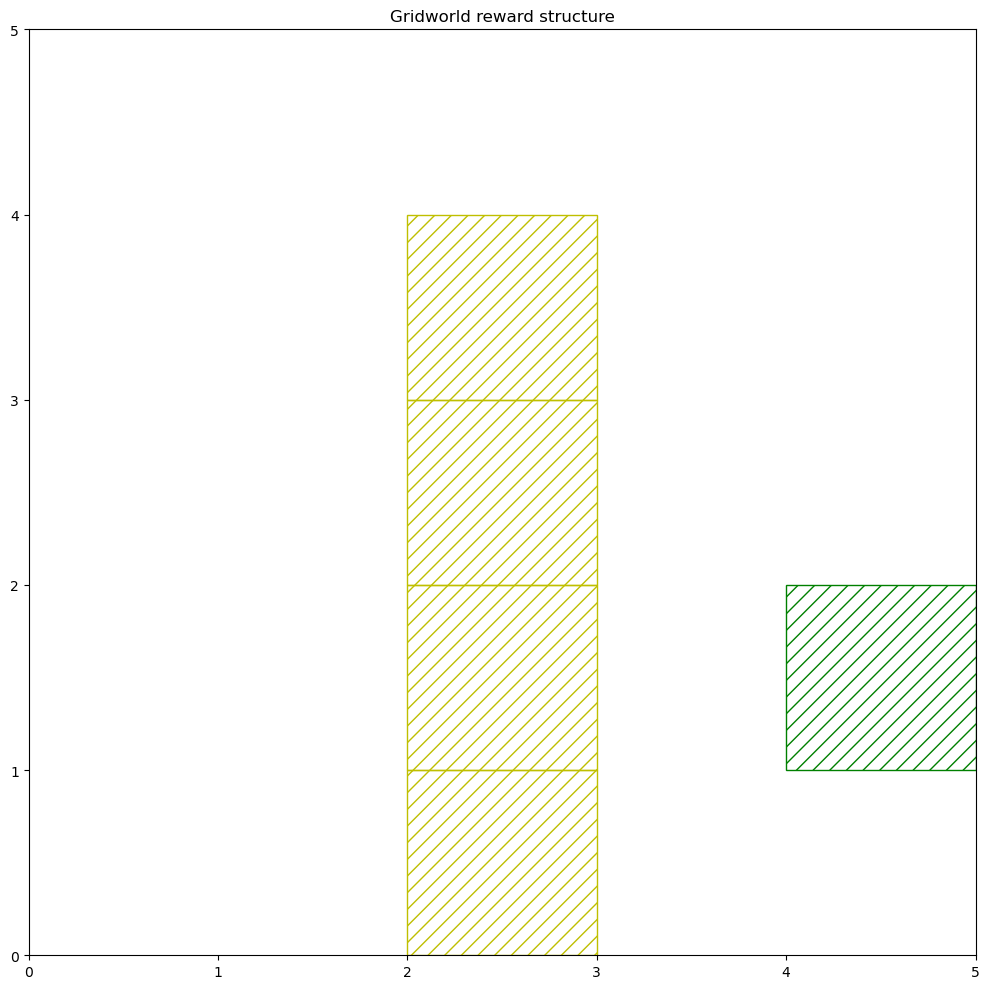

In [2]:
R = 100
P = -200
goals = [((4,1),R),((2,0),P),((2,1),P),((2,2),P),((2,3),P)]
gridMDP = Gridworld(5,5,0.1,0.9,goals=goals,obstacles=[]) 
gridMDP.init_distrib =  jnp.exp(jax.random.uniform(key,(gridMDP.n,))) / \
    jnp.sum(jnp.exp(jax.random.uniform(key,(gridMDP.n,))))
    
    
fig, ax = plt.subplots(1,figsize=(10,10))
gridplot(gridMDP,ax,goals=goals)
ax.set_title('Gridworld reward structure')
fig.tight_layout()
plt.show()

### Policy Gradient using First order oracles

In [3]:
STEPS = 30
LR = 1
theta = jax.random.uniform(key,(gridMDP.n,gridMDP.m))
pi_theta = nn.softmax(theta,axis=1)

parametrization = lambda p : nn.softmax(p,axis=1)
vanillaGrad = vanillaGradOracle(gridMDP, None, key, parametrization, 1,1)

def logger(theta):
    return {
        'theta': theta,
        'pi': parametrization(theta),
        'J': gridMDP.J(parametrization(theta))
    }
        
alg = PolicyGradientMethod(gridMDP,key,vanillaGrad,logger)
log, theta = alg.train(STEPS,LR)

100%|██████████| 30/30 [00:01<00:00, 21.98it/s]


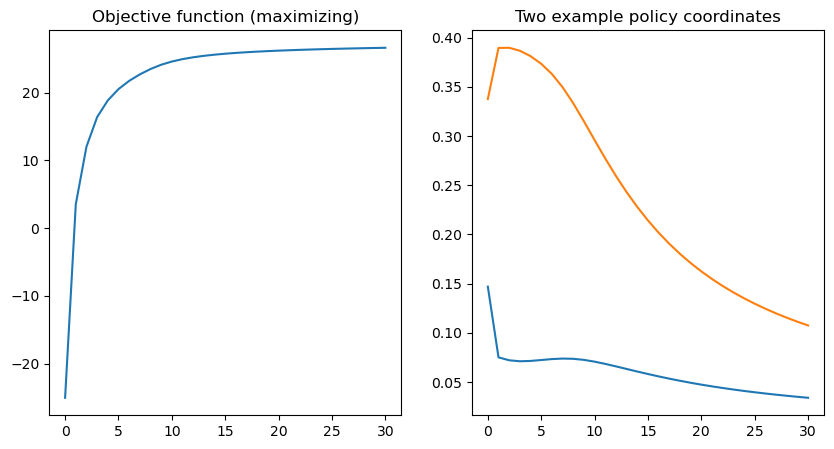

In [4]:
pis=jnp.stack([e['pi'] for e in log])
js=jnp.stack([e['J'] for e in log])
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(js)
ax[0].set_title('Objective function (maximizing)')
ax[1].plot(pis[:,0,:2])
ax[1].set_title('Two example policy coordinates')
plt.show()

#### Computing the Fisher Information Matrix

Recall that the Fisher Information Matrix (FIM) is given by:
$$
\mathcal{F}_\theta = \mathbb{E}_{s,a \sim \theta} \Big[ (\nabla_\theta \log \pi_\theta(a|s)) (\nabla_\theta \log \pi_\theta(a|s))^\top \Big]
$$

Given exact knowledge of the MDP we can compute it as follows:
1. we let `jac` denote the Jacobian of $\log \pi$ w.r.t $\theta$:
$$
\text{jac} = 
\begin{bmatrix}
\frac{\partial \log \pi(a_1|s_1)  }{\partial \theta(s_1,a_1)  }
& ... & \frac{\partial \log \pi(a_1|s_1)  }{\partial \theta(s_n,a_m)  } \\
\vdots & \ddots & \vdots \\
\frac{\partial \log \pi(a_m|s_n)  }{\partial \theta(s_1,a_1)  }
& ... & \frac{\partial \log \pi(a_m|s_n)  }{\partial \theta(s_n,a_m)  }
\end{bmatrix}
\in \mathbb{R}^{nm\times nm}
$$
2. We then batch-compute the outer product $(\nabla_\theta \log \pi_\theta(a|s)) (\nabla_\theta \log \pi_\theta(a|s))^\top$ for each $(s,a)$ pair (which we store in the `bop` tensor)
$$
\text{bop} = 
\begin{bmatrix}
    (\nabla_\theta \log \pi_\theta(a_1|s_1)) (\nabla_\theta \log \pi_\theta(a_1|s_1))^\top\\
    \vdots \\
    (\nabla_\theta \log \pi_\theta(a_m|s_n)) (\nabla_\theta \log \pi_\theta(a_m|s_n))^\top
\end{bmatrix}
\in \mathbb{R}^{nm\times nm\times nm}
$$
3. Finally we compute the FIM by taking the sum weighted by the occupancy measure:
$$
\mathcal{F}_\theta = \sum_{(s,a) \in S \times A}\mu_\theta(a,s) \cdot (\nabla_\theta \log \pi_\theta(a|s)) (\nabla_\theta \log \pi_\theta(a|s))^\top\\
$$

And then the natural gradient step is simply given by preconditionning the gradients with the Moore-Penrose Inverse of the exact fisher information matrix:
$$
g_t = \mathcal{F}_{\theta_t}^{\dagger}\nabla_\theta J(\theta_t) 
$$

#### Natural PG methods

Here we compare convergence with the vanilla and the NPG approach

100%|██████████| 30/30 [00:00<00:00, 49.07it/s]


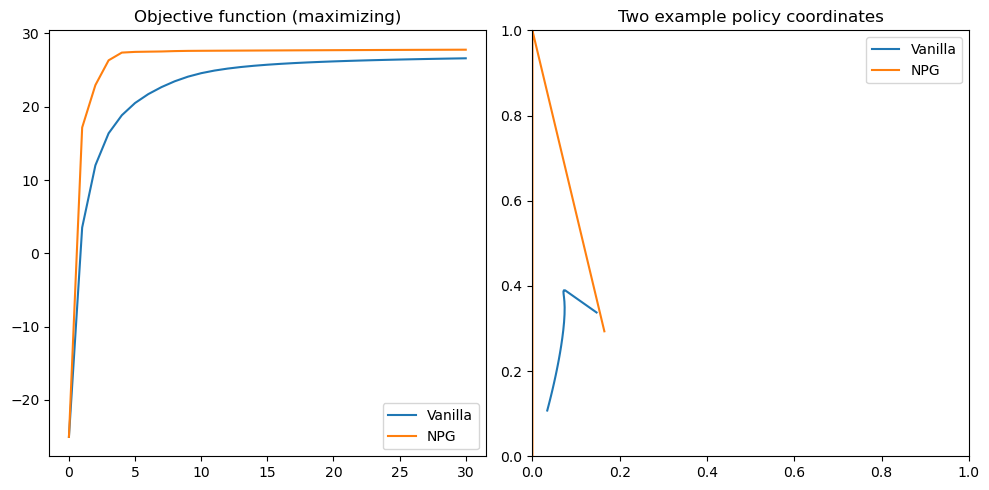

In [5]:
STEPS = 30
V_LR = 1
N_LR = 1e-1
naturalGrad = naturalGradOracle(gridMDP, None, key, parametrization, 1,1)

alg_vanilla = PolicyGradientMethod(gridMDP,key,vanillaGrad,logger)
alg_natural = PolicyGradientMethod(gridMDP,key,naturalGrad,logger)

log_vpg, t_v = alg_vanilla.train(STEPS,V_LR)
log_npg, t_n = alg_natural.train(STEPS,N_LR)

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].set_title('Objective function (maximizing)');ax[1].set_title('Two example policy coordinates')

pis=jnp.stack([e['pi'] for e in log_vpg])
js=jnp.stack([e['J'] for e in log_vpg])
ax[0].plot(js); ax[1].plot(pis[:,0,0],pis[:,0,1])
pis=jnp.stack([e['pi'] for e in log_npg])
js=jnp.stack([e['J'] for e in log_npg])
ax[0].plot(js); ax[1].plot(pis[:,1,0],pis[:,1,1])
ax[1].set_xlim([0,1]);ax[1].set_ylim([0,1])
ax[0].legend(['Vanilla','NPG'])
ax[1].legend(['Vanilla','NPG'])
fig.tight_layout()
plt.show()

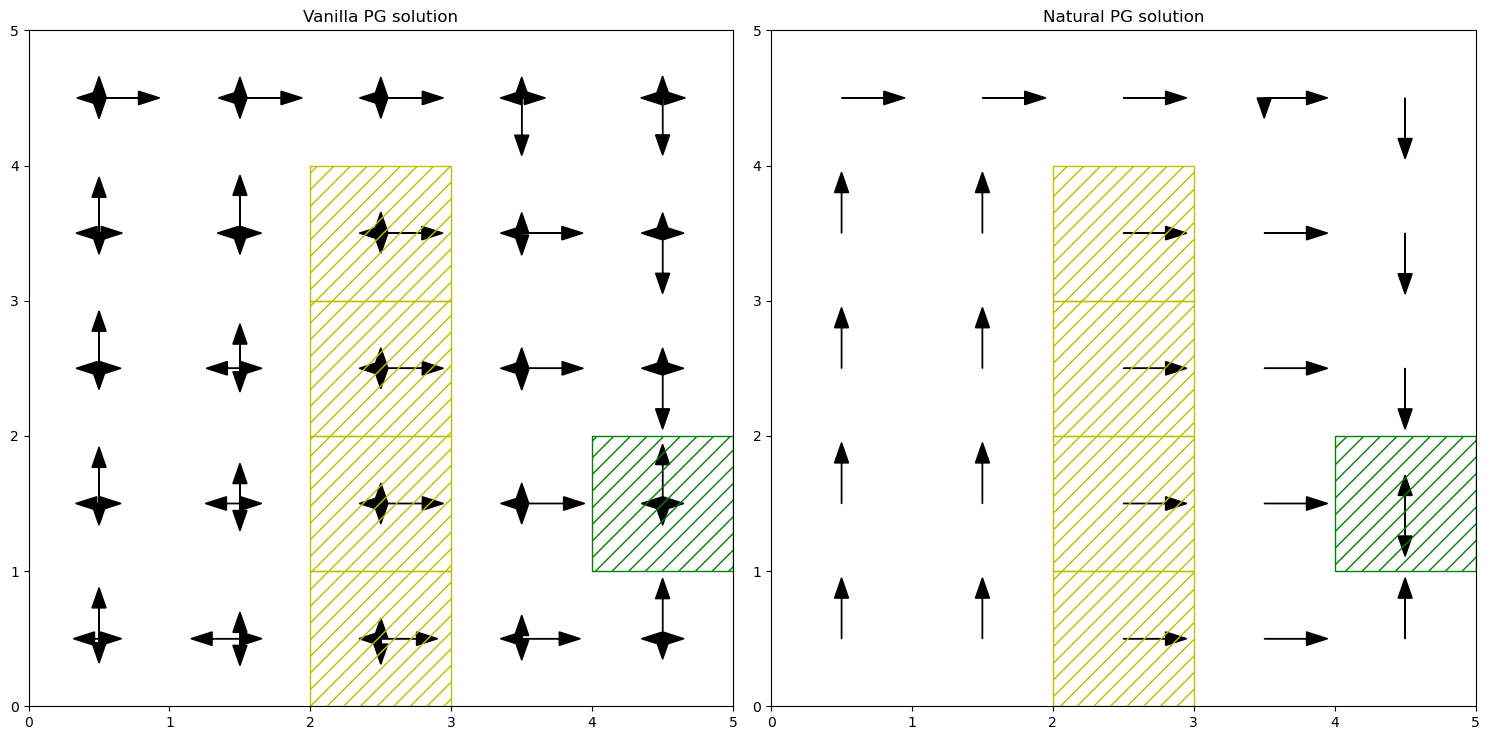

In [6]:
fig, ax = plt.subplots(1,2,figsize=(1.5*10,1.5*5))
gridplot(gridMDP,ax[0],stochastic_policy=nn.softmax(t_v,axis=1),goals=goals)
ax[0].set_title('Vanilla PG solution')
gridplot(gridMDP,ax[1],stochastic_policy=nn.softmax(t_n,axis=1),goals=goals)
ax[1].set_title('Natural PG solution')
fig.tight_layout()

### Policy Gradient using Monte-Carlo methods

Now the trick is that rather than directly computing the gradients using our full knowledge of the MDP we will estimate it with Monte-Carlo methods. To do so we will first collect a dataset generated by the current policy and then we will run a gradient estimator such as *GPOMDP*.

### Implementing a Sampling Routine

We sample batches of trajectories of the following form:
$$
\mathcal{B} = 
\Bigg\{
    \Bigg\{ 
        \big(
            s_t^b,   
            a_t^b,
            r_t^b    
        \big)
    \Bigg\}_{h=0}^H
\Bigg\}_{b=0}^B,
$$
each batch contains $B$ trajectories of horizon $H$.

In [7]:
sampler = Sampler(gridMDP,key)

#### Estimating Policy Gradients from the Batches

We implement the `GPOMDP` estimator which has the following form:
$$
g_\theta = 
\frac{1}{B} \sum^B_{i=1} \sum^{H-1}_{h=0}
\Big( \sum^{h}_{j=0} \nabla_\theta \log \pi_\theta(a_j^i|s_j^i) \cdot r_h^i \Big)
\approx \nabla_\theta J(\theta)
$$

In [8]:
H=10


In [9]:
STEPS = 10
LR = 1
HORIZON = 20
BATCH = 20

mCVanillaGrad = monteCarloVanillaGrad(
                               gridMDP,
                               sampler,
                               key,
                               parametrization,
                               HORIZON,BATCH)

alg_mc_vanilla = PolicyGradientMethod(gridMDP,key,mCVanillaGrad,logger)
log, theta = alg_mc_vanilla.train(STEPS,LR)

100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


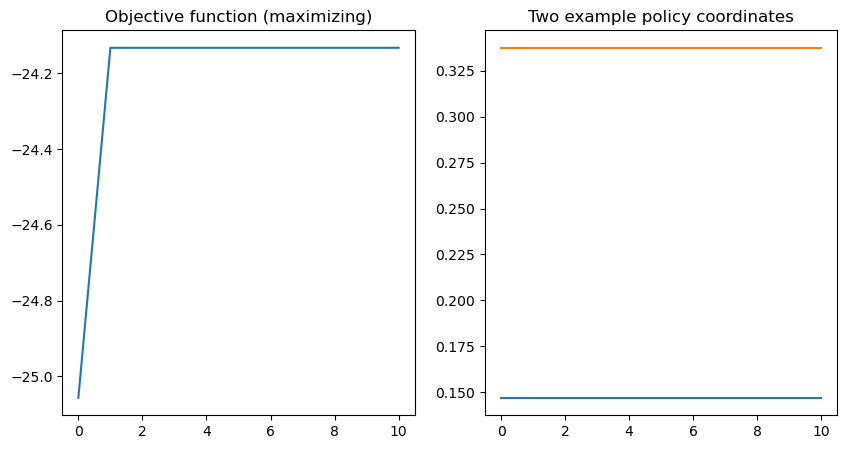

In [10]:
pis=jnp.stack([e['pi'] for e in log])
js=jnp.stack([e['J'] for e in log])
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(js)
ax[0].set_title('Objective function (maximizing)')
ax[1].plot(pis[:,0,:2])
ax[1].set_title('Two example policy coordinates')
plt.show()

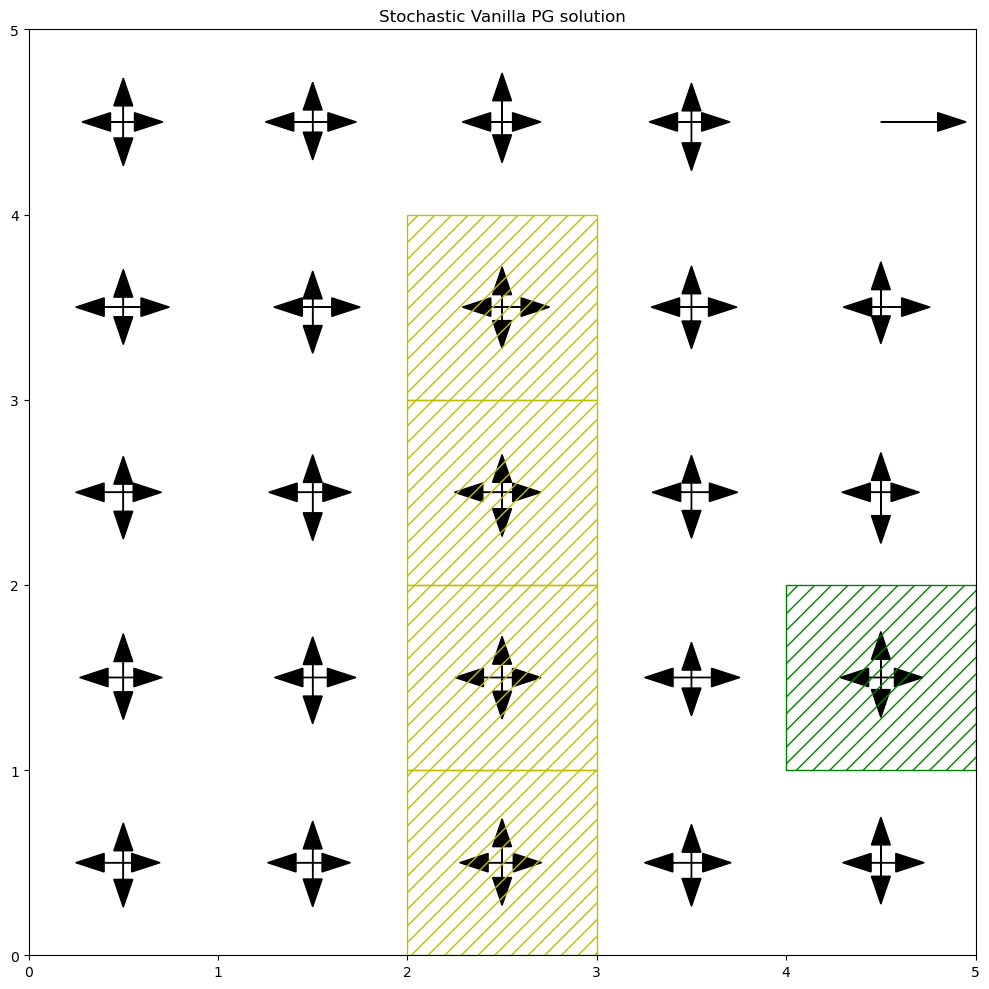

In [11]:
fig, ax = plt.subplots(1,figsize=(10,10,))
gridplot(gridMDP,ax,stochastic_policy=pis[-1],goals=goals)
ax.set_title('Stochastic Vanilla PG solution')
fig.tight_layout()

#### Sampling the FIM 

Recall that the Fisher Information Matrix (FIM) is given by:
$$
\mathcal{F}_\theta = \mathbb{E}_{s,a \sim \theta} \Big[ (\nabla_\theta \log \pi_\theta(a|s)) (\nabla_\theta \log \pi_\theta(a|s))^\top \Big],
$$
we can estimate it from a batch as follows:
$$
\tilde{\mathcal{F}}_\theta = 
\frac{1}{B \cdot H}
\Bigg[ \sum_{h=0}^{H-1} \sum_{b=1}^B (\nabla_\theta \log \pi_\theta(a|s)) (\nabla_\theta \log \pi_\theta(a|s))^\top \Bigg].
$$

In [12]:
HORIZON = 5
BATCH = 5

mCVanillaGrad = monteCarloVanillaGrad(
                               gridMDP,
                               sampler,
                               key,
                               parametrization,
                               HORIZON,BATCH)

mCNaturalGrad = monteCarloNaturalGrad(
                               gridMDP,
                               sampler,
                               key,
                               parametrization,
                               HORIZON,BATCH)

alg_mc_vanilla = PolicyGradientMethod(gridMDP,key,mCVanillaGrad,logger)
alg_mc_natural = PolicyGradientMethod(gridMDP,key,mCNaturalGrad,logger,clip_thresh=5e3)
log_v, theta_v = alg_mc_vanilla.train(10,1)
log_n, theta_n = alg_mc_natural.train(10,7e-2)

100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


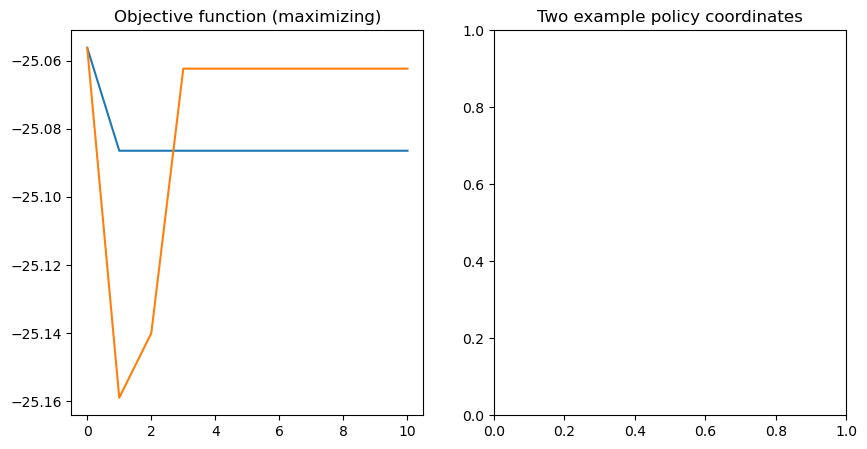

In [14]:
PI_COORD = 3
def plot_perf_pis(log,ax):
    js=jnp.stack([e['J'] for e in log])
    pis=jnp.stack([e['pi'] for e in log])
    ax[0].plot(js)
    ax[1].plot(pis[:,PI_COORD,0],pis[:,PI_COORD,1])
    
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_perf_pis(log_v,ax)
plot_perf_pis(log_n,ax)
ax[0].set_title('Objective function (maximizing)')
ax[1].set_title('Two example policy coordinates')
ax[1].set_xlim([0,1]);ax[1].set_ylim([0,1])
plt.show()

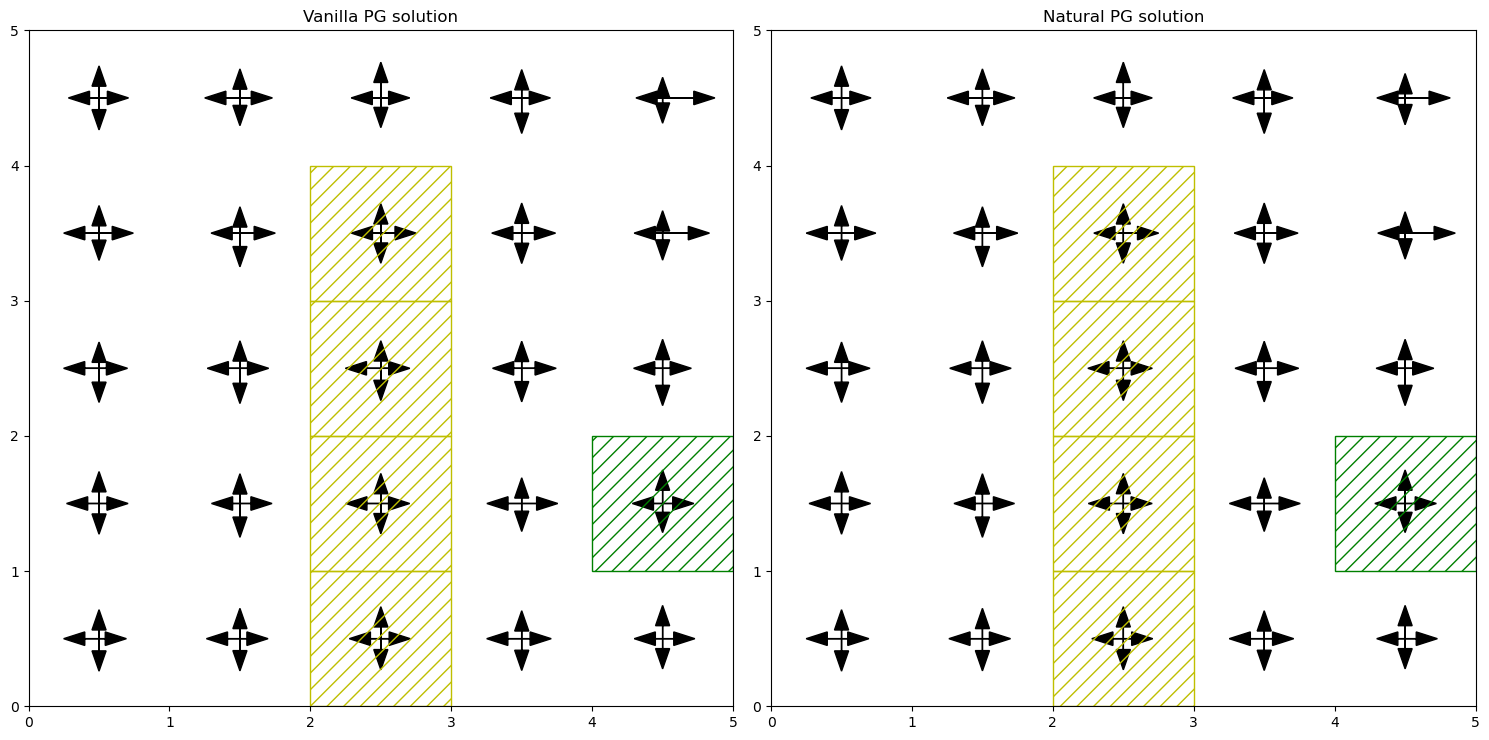

In [15]:
def get_trained_policy(log):
    pis=jnp.stack([e['pi'] for e in log])
    return pis[-1]

fig, ax = plt.subplots(1,2,figsize=(1.5*10,1.5*5))
gridplot(gridMDP,ax[0],stochastic_policy=get_trained_policy(log_v),goals=goals)
ax[0].set_title('Vanilla PG solution')
gridplot(gridMDP,ax[1],stochastic_policy=get_trained_policy(log_n),goals=goals)
ax[1].set_title('Natural PG solution')
fig.tight_layout()

### Vector Mapping the sampling routines

##### Pre-vectorization code (for reference)

In [18]:
""" Generic sampling routines for MDPs """
def sample_trajectory(pi,mdp,smp,H,key):
    def pick_action(pi,s,mdp):
        p = pi[s]; p /= jnp.sum(p)
        return jax.random.choice(key,jnp.arange(mdp.m), p = p)
        
    traj = []
    r_t = 0
    s_t = smp.reset(key=key)
    for _ in range(H):
        a_t = pick_action(pi,s_t,mdp)
        traj += [(s_t,a_t,r_t)]
        s_t, r_t = smp.step(a_t)
    return traj
def sample_batch(pi,mdp,smp,H,B,key):
    subkeys = jax.random.split(key,B)
    return [sample_trajectory(pi,mdp,smp,H,k) for k in subkeys]

In [19]:
def gpomdp(batch,theta,B,H,gamma):
    def g_log(theta,s,a):
        return jax.grad(lambda p : jnp.log(nn.softmax(p,axis=1))[s,a])(theta)
    def trace_grad(batch,theta,b,h):
        return jnp.sum(jnp.array([g_log(theta,e[0],e[1]) for e in batch[b][:h]]),axis=0)
    def single_sample_gpomdp(batch,theta,b,H):
        return jnp.sum(jnp.array([(gamma**h)*batch[b][h][2] \
                    *trace_grad(batch,theta,b,h) for h in range(1,H)]),axis=0)
        
    return (1/B)*jnp.sum(jnp.array([single_sample_gpomdp(batch,theta,b,H) for b in range(B)]),axis=0)


In [20]:
%timeit sample_trajectory(parametrization(theta),gridMDP,sampler,10,key)

37.1 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
%timeit batch = sample_batch(parametrization(theta),gridMDP,sampler,10,20,key)
batch = sample_batch(parametrization(theta),gridMDP,sampler,10,20,key)

754 ms ± 36.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
H=20
B=10
%timeit gpomdp(batch,theta,H,B,gridMDP.gamma)

6.83 s ± 494 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


##### Vectorized implementation

In [33]:
def fast_gpomdp(batch,theta,H,B,gamma,parametrization):
    s_batch = jnp.array([[e[0] for e in s] for s in batch])
    a_batch = jnp.array([[e[1] for e in s] for s in batch])
    r_batch = jnp.array([[e[2] for e in s] for s in batch])

    def g_log(s,a,theta,parametrization):
        return jax.grad(lambda p : jnp.log(parametrization(p))[s,a])(theta)
    _f = lambda s,a : g_log(s,a,theta,parametrization)


    batch_grads = jax.vmap(jax.vmap(_f))(s_batch, a_batch) ##vmap can only operate on a single axis 
    summed_grads = jnp.cumsum(batch_grads,axis=0)

    gamma_tensor = gamma**jnp.arange(H)
    gamma_tensor = jnp.repeat(jnp.repeat(jnp.repeat(
        gamma_tensor[:, jnp.newaxis, jnp.newaxis, jnp.newaxis], 
            B, axis=1),
                summed_grads.shape[2],axis=2),
                    summed_grads.shape[3],axis=3)

    reward_grads = summed_grads*jnp.repeat(jnp.repeat(
        r_batch[:, :, jnp.newaxis, jnp.newaxis], 
        summed_grads.shape[2], axis=2),
            summed_grads.shape[3],axis=3) * gamma_tensor
    return jnp.sum(reward_grads,axis=(0,1))
%timeit fast_gpodmp(batch,theta,H,B,gridMDP.gamma,parametrization)

104 ms ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
slowgrad = gpomdp(batch,theta,H,B,gridMDP.gamma)
fastgrad = fast_gpomdp(batch,theta,H,B,gridMDP.gamma,parametrization)

In [36]:
jnp.linalg.norm(slowgrad-fastgrad)

DeviceArray(nan, dtype=float64)

In [38]:
print(slowgrad)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.83818967e+00  2.52073904e+00  2.12994299e+00  2.18750764e+00]
 [-2.13841455e+01  6.55527329e+00  7.68993024e+00  7.13894200e+00]
 [-7.98316096e-01  3.26964911e-01  1.87909366e-01  2.83441818e-01]
 [-3.58490506e+00  8.36817120e-01  1.55718127e+00  1.19090667e+00]
 [ 1.27322921e-01 -4.98156347e-01  1.95498111e-01  1.75335316e-01]
 [ 8.06650508e-02 -1.36318724e-01  7.26513355e-02 -1.69976624e-02]
 [ 1.68440126e+00 -6.16899354e+00  2.21080697e+00  2.27378532e+00]
 [ 3.34525214e+01 -1.67592076e+01 -6.88680177e+00 -9.80651201e+00]
 [-1.60543126e+01  5.25676411e+01 -2.19274853e+01 -1.45858431e+01]
 [ 2.06292982e-01 -7.85736336e-01  1.74254171e-01  4.05189182e-01]
 [ 4.93821212e-02  7.51173575e-02 -1.04884267e-01 -1.96152112e-02]
 [ 1.70545323e+00 -6.04603123e+00  1.64082174e+00  2.69975626e+00]
 [ 6.00101993e-02  3.61654241e-02 -1.58396866e-01  6.22212429e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e

In [37]:
print(fastgrad)

[[   0.            0.            0.            0.        ]
 [  -6.01119094  -10.70463984   -9.04507458   25.76090536]
 [-253.44062599   77.69179109   91.13951879   84.60931611]
 [-209.98524476   86.00328531   49.42678032   74.55517912]
 [  -4.58998332    1.0714305     1.99375881    1.524794  ]
 [ -29.80950902  116.63097301  -45.77104158  -41.05042241]
 [  40.46519443 -142.04165538   36.44515673   65.13130421]
 [   0.            0.            0.            0.        ]
 [ 121.90441575  -61.0722698   -25.09621134  -35.73593462]
 [   5.9932403   -19.62404197    8.18575618    5.44504549]
 [  -6.07507829   23.13898272   -5.13157413  -11.9323303 ]
 [  56.68051516   86.21927171 -258.80844624  115.90865937]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]
 [ -28.27320736   86.69885481  -42.73616529  -15.68948216]
 [  -4.11157794   26.65655065   -1.81864976  -20.7263229